# Setup the database

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import cv2
import glob
import numpy as np
import os
import pandas as pd

print(tf.__version__)

2.0.0-alpha0


In [2]:
IMAGE_FOLDER = "/mnt/cache/mongo"
IMAGE_SHAPE = (32, 32)

In [3]:
from nltk.corpus import stopwords
stop = stopwords.words('french')

In [7]:
store_references = pd.read_csv("/mnt/cache/store_references.csv")

In [8]:
import ast
def get_first_node(x):
    try:
        return ast.literal_eval(x)[0]
    except:
        return None

In [9]:
store_references['first_node'] = store_references['classification.v0_3.node_ids'].apply(get_first_node)

In [10]:
store_references.head()

,_id,brand_name,label,packaging,classification.v0_3.node_ids,classification.v0_3.classified_by,first_node
0,ObjectId(51d2c538c0569c851c000002),Mentos,Chewing-gum Full Ice menthe réglisse sans sucres,la boite de 50 - 100 g,"[""node-epicerie-sucree"",""node-confiseries"",""no...",admin,node-epicerie-sucree
1,ObjectId(51d2c538c0569c851c000003),Mentos,Bonbons tendres dragéifiés Fruit,les 4 rouleaux de 38 g,"[""node-epicerie-sucree"",""node-confiseries"",""no...",admin,node-epicerie-sucree
2,ObjectId(51d2c538c0569c851c000005),Glen Grant,Scotch whisky single malt,la bouteille de 70 cl,"[""node-boissons"",""node-spiritueux"",""node-eaux-...",admin,node-boissons
3,ObjectId(51d2c538c0569c851c000006),Alsa,Gâteau de semoule nappé de caramel,la boite de 414 g,"[""node-epicerie-sucree"",""node-aides-patisserie...",ClassificationEngine,node-epicerie-sucree
4,ObjectId(51d2c538c0569c851c000009),Dillon,Rhum blanc agricole Martinique,la bouteille de 100 cl,"[""node-boissons"",""node-spiritueux"",""node-eaux-...",admin,node-boissons


In [11]:
store_references_filtered = store_references.dropna().set_index("_id")

In [12]:
# Filter the references based on the file we have
images_files = glob.glob("{}/*.jpg".format(IMAGE_FOLDER))

def get_file_path(oid):
    return "{}/{}.jpg".format(IMAGE_FOLDER, oid)

def file_exists(oid):
    filename = get_file_path(oid)
    return os.path.isfile(filename)

def get_image_array(oid):
    filename = get_file_path(oid)
    if file_exists(oid):
        try:
            return np.array(cv2.resize(cv2.imread(filename), IMAGE_SHAPE) / 255)
        except Exception as e:
            return pd.np.array()
        
def is_valid_image(oid):
    filename = get_file_path(oid)
    if file_exists(oid):
        try:
            np.array(cv2.resize(cv2.imread(filename), IMAGE_SHAPE) / 255)
            return True
        except Exception as e:
            return False

In [13]:
store_references_filtered.shape

(427908, 6)

In [14]:
# We remove references which have no picture
store_references_filtered['has_file'] = store_references_filtered.index.map(file_exists)
store_references_filtered = store_references_filtered[store_references_filtered['has_file']]
store_references_filtered['filepath'] = store_references_filtered.index.map(get_file_path)

# Remove very small categories
store_references_filtered = store_references_filtered[~store_references_filtered.first_node.isin([
    "node-junk",
    "node-cuisine-ustensiles",
    "node-glacons",
    "node-outillage",
    "node-peinture-droguerie"
])]

In [15]:
store_references_filtered.shape

(261711, 8)

In [16]:
# Remove store references which have invalid pictures
# Time consuming
store_references_filtered['is_valid'] = store_references_filtered.index.map(is_valid_image)

In [17]:
store_references_filtered.is_valid.sum()

226602

In [18]:
store_references_filtered = store_references_filtered[store_references_filtered['is_valid']]

In [19]:
store_references_filtered.shape

(226602, 9)

In [20]:
store_references_filtered['first_node'] = pd.Categorical(store_references_filtered['first_node'])
store_references_filtered['fn'] = store_references_filtered['first_node'].cat.codes
class_names = store_references_filtered['first_node'].cat.categories

In [21]:
class_names

Index(['node-animaux', 'node-bazar', 'node-bebe', 'node-boissons',
       'node-entretien-nettoyage', 'node-epicerie-salee',
       'node-epicerie-sucree', 'node-hygiene-beaute', 'node-produits-frais',
       'node-surgele'],
      dtype='object')

In [23]:
store_references_filtered['fn'].unique()

array([6, 3, 9, 7, 5, 8, 2, 4, 1, 0])

In [24]:
X = store_references_filtered[['label', 'first_node', 'fn', 'filepath']]
y = store_references_filtered[['fn']]

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
len(X_train.first_node.unique())

10

In [27]:
len(X_test.first_node.unique())

10

### Deep learning classification using textual informations

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    strip_accents="unicode",
    stop_words=stop,
    ngram_range=(1,1),
    analyzer="word")
vectorizer.fit(X_train['label'])

train_data = vectorizer.transform(X_train['label'])
test_data = vectorizer.transform(X_test['label'])

In [29]:
vocab_size = len(vectorizer.vocabulary_)

nlp_model = keras.Sequential()
nlp_model.add(keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=10,
    input_length=vocab_size))
nlp_model.add(keras.layers.Flatten())
nlp_model.add(keras.layers.Dense(128, activation=tf.nn.relu))
nlp_model.add(keras.layers.Dense(len(store_references_filtered['fn'].unique()), activation=tf.nn.softmax))
nlp_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18371, 10)         183710    
_________________________________________________________________
flatten (Flatten)            (None, 183710)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               23515008  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 23,700,008
Trainable params: 23,700,008
Non-trainable params: 0
_________________________________________________________________


In [30]:
nlp_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [31]:
train_size = int(train_data.shape[0] * 2 / 3)

In [32]:
x_val = train_data[train_size:]
partial_x_train = train_data[:train_size]

y_val = train_labels[train_size:].values
partial_y_train = train_labels[:train_size].values

In [33]:
partial_y_train

array([[2],
       [5],
       [8],
       ...,
       [1],
       [8],
       [6]], dtype=int8)

In [34]:
history = nlp_model.fit(partial_x_train,
                        partial_y_train,
                        epochs=5,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)

Train on 101215 samples, validate on 50608 samples
Epoch 1/5
101215/101215 [==============================] - 330s 3ms/sample - loss: 2.0924 - accuracy: 0.2701 - val_loss: 1.6921 - val_accuracy: 0.5006
Epoch 2/5
101215/101215 [==============================] - 328s 3ms/sample - loss: 1.1019 - accuracy: 0.6731 - val_loss: 0.6774 - val_accuracy: 0.8011
Epoch 3/5
101215/101215 [==============================] - 328s 3ms/sample - loss: 0.5220 - accuracy: 0.8511 - val_loss: 0.4298 - val_accuracy: 0.8727
Epoch 4/5
101215/101215 [==============================] - 328s 3ms/sample - loss: 0.3622 - accuracy: 0.8941 - val_loss: 0.3435 - val_accuracy: 0.8932
Epoch 5/5
101215/101215 [==============================] - 326s 3ms/sample - loss: 0.2912 - accuracy: 0.9137 - val_loss: 0.3017 - val_accuracy: 0.9096


In [35]:
results = nlp_model.evaluate(test_data, test_labels)

print(results)

74779/74779 [==============================] - 52s 690us/sample - loss: 0.3077 - accuracy: 0.9075
[0.30774461301332695, 0.90746063]


### Simple classification using SVM

In [36]:
from sklearn import svm
lin_clf = svm.LinearSVC()
lin_clf.fit(train_data, train_labels)

/home/admin/.pyenv/versions/3.4.1/envs/notification-engine/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [37]:
test_pred = lin_clf.predict(test_data)

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, test_pred)

0.9271319488091576

### Deep learning classification using images

#### Plot the images

In [39]:
import matplotlib.pyplot as plt

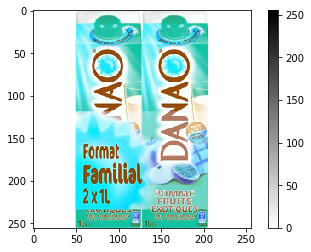

In [40]:
img = cv2.imread(images_files[1])
plt.figure()
plt.imshow(cv2.resize(img, (256, 256)), cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [41]:
def generate_arrays_from_file(df):
    while True:
        for i, row in df.iterrows():
            image = get_image_array(i)
            print(image.shape)
            
            if len(image):
                yield (image, row['fn'])
            else:
                continue

In [ ]:
# This part was used when all the picture could fit in memory

# images = pd.np.array([get_image_array(i) for i, row in store_references_filtered.iterrows()])
# store_references_filtered['image'] = store_references_filtered.index.map(get_image_array)

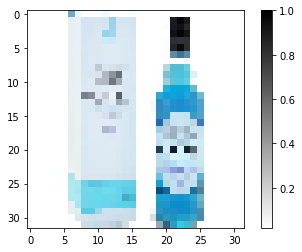

In [42]:
img = get_image_array(store_references_filtered.index[2])
plt.figure()
plt.imshow(img, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

#### Init the model

In [43]:
import keras.utils.vis_utils as vutils
from keras_preprocessing.image import ImageDataGenerator
from IPython.display import SVG

Using TensorFlow backend.


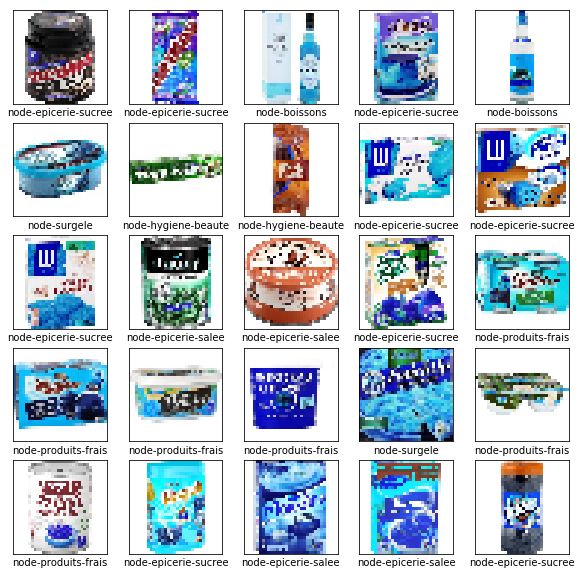

In [44]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(get_image_array(store_references_filtered.index[i]), cmap=plt.cm.binary)
    plt.xlabel(store_references_filtered['first_node'].iloc[i])
plt.show()

In [45]:
simple_model = keras.Sequential([
    keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)),
    keras.layers.Conv2D(16, (5, 5), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(len(store_references_filtered.fn.unique()), activation=tf.nn.softmax)
])
# SVG(vutils.model_to_dot(simple_model).create(prog='dot', format='svg'))

In [46]:
complex_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),    
    keras.layers.Dense(len(store_references_filtered.fn.unique()), activation=tf.nn.softmax)
])
# SVG(vutils.model_to_dot(complex_model).create(prog='dot', format='svg'))

In [47]:
simple_model.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
complex_model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [55]:
# train_images = np.stack(X_train['image'].values)
# test_images = np.stack(X_test['image'].values)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=IMAGE_FOLDER,
    x_col="filepath",
    y_col="fn",
    subset="training",
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=IMAGE_SHAPE,
    batch_size=32,
    
)

validation_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=IMAGE_FOLDER,
    x_col="filepath",
    y_col="fn",
    subset="validation",
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=IMAGE_SHAPE,
    batch_size=32,
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=IMAGE_FOLDER,
    x_col="filepath",
    y_col="fn",
    shuffle=False,
    seed=42,
    save_to_dir=os.path.join(IMAGE_FOLDER, "test_processed"),
    class_mode="other",
    target_size=IMAGE_SHAPE,
    batch_size=32
)

Found 113868 images.
Found 37955 images.
Found 74779 images.


In [56]:
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [57]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [58]:
simple_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=5,
    use_multiprocessing=True
)

Epoch 1/5
3558/3558 [==============================] - 816s 229ms/step - loss: 1.6242 - accuracy: 0.4335 - val_loss: 1.4896 - val_accuracy: 0.4898
Epoch 2/5
3558/3558 [==============================] - 821s 231ms/step - loss: 1.3660 - accuracy: 0.5285 - val_loss: 1.3729 - val_accuracy: 0.5294
Epoch 3/5
3558/3558 [==============================] - 817s 230ms/step - loss: 1.2448 - accuracy: 0.5728 - val_loss: 1.3604 - val_accuracy: 0.5418
Epoch 4/5
3558/3558 [==============================] - 816s 229ms/step - loss: 1.1707 - accuracy: 0.5984 - val_loss: 1.3409 - val_accuracy: 0.5490
Epoch 5/5
3558/3558 [==============================] - 807s 227ms/step - loss: 1.1141 - accuracy: 0.6170 - val_loss: 1.3647 - val_accuracy: 0.5499


In [59]:
simple_model.evaluate_generator(
    generator=validation_generator,
    steps=STEP_SIZE_VALID,
    use_multiprocessing=True
)

[1.3647009288078618, 0.5498788]

In [60]:
simple_model.evaluate_generator(
    generator=test_generator,
    steps=STEP_SIZE_TEST,
    use_multiprocessing=True
)

[1.3816910503202513, 0.5449219]

In [61]:
complex_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=5,
    use_multiprocessing=True
)

Epoch 1/5
3558/3558 [==============================] - 821s 231ms/step - loss: 1.6401 - accuracy: 0.4240 - val_loss: 1.3895 - val_accuracy: 0.5159
Epoch 2/5
3558/3558 [==============================] - 814s 229ms/step - loss: 1.4073 - accuracy: 0.5106 - val_loss: 1.2670 - val_accuracy: 0.5678
Epoch 3/5
3558/3558 [==============================] - 817s 230ms/step - loss: 1.3092 - accuracy: 0.5459 - val_loss: 1.1877 - val_accuracy: 0.5940
Epoch 4/5
3558/3558 [==============================] - 810s 228ms/step - loss: 1.2461 - accuracy: 0.5701 - val_loss: 1.1414 - val_accuracy: 0.6092
Epoch 5/5
3558/3558 [==============================] - 811s 228ms/step - loss: 1.1997 - accuracy: 0.5860 - val_loss: 1.1542 - val_accuracy: 0.6086


In [ ]:
complex_model.evaluate_generator(
    generator=validation_generator,
    steps=STEP_SIZE_VALID,
    use_multiprocessing=True
)

In [ ]:
complex_model.evaluate_generator(
    generator=test_generator,
    steps=STEP_SIZE_TEST,
    use_multiprocessing=True
)

#### Global results

Results for dimension 32 x 32
```
simple    5 epoch: 0.5449219
complex   5 epoch: 
```

Results for dimension 64 x 64
```
simple    5 epoch: 0.6521547
complex   5 epoch: 0.7081523
complex  20 epoch: 0.7815187
complex 100 epoch: 0.8111888
```

Results for dimension 128 x 128
```
simple    5 epoch: 0.7196597
complex   5 epoch: 
complex  20 epoch: 
complex 100 epoch: 
```

### Complexify the ImageDataGenerator

In [ ]:
new_args = dict(shear_range=0.2,
                zoom_range=0.3,
                rotation_range=180,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=False,
                vertical_flip=True)

### Combine NLP and Image model

In [64]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

In [65]:
# combine the output of the two branches
combined = concatenate([nlp_model.output, simple_model.output])

In [66]:
mixed_model = keras.layers.Dense(len(store_references_filtered.first_node.unique()), activation=tf.nn.relu)(combined)
mixed_model = keras.layers.Dense(len(store_references_filtered.first_node.unique()), activation=tf.nn.softmax)(mixed_model)
 
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[nlp_model.input, simple_model.input], outputs=mixed_model)

In [67]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.preprocessing import image as krs_image
datagen = ImageDataGenerator()
data_gen_args = dict(
    rescale=1. / 255
)
def custom_generator(df, batch_size):
    i = 0
    while True:
        batch = {'images': [], 'labels': [], 'categories': []}
        for b in range(batch_size):
            if i == len(df):
                i = 0
                df = df.sample(frac=1)

            row = df.iloc[i]

            image_path = row['filepath']
            label = row['label']
            category = row['fn']
            row.drop(labels='fn')

            # Process image
            image = krs_image.load_img(image_path, target_size=IMAGE_SHAPE)
            image = datagen.apply_transform(image, data_gen_args)
            image = krs_image.img_to_array(image)

            # Process label
            label = vectorizer.transform([label]).toarray()[0]

            batch['images'].append(image)
            batch['labels'].append(label)
            batch['categories'].append(category)

            i += 1

        batch['images'] = np.array(batch['images'])
        batch['labels'] = np.array(batch['labels'])

        # Convert labels to categorical values
        # batch['labels'] = np.eye(num_classes)[batch['labels']]
        batch['categories'] = np.array(batch['categories'])
        
        yield [batch['labels'], batch['images']], batch['categories']

In [ ]:
custom_gen = custom_generator(df=X_train, batch_size=32)

model.fit_generator(
    custom_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=5,
    use_multiprocessing=True
)

Epoch 1/5
3558/3558 [==============================] - 626s 176ms/step - loss: 0.5839 - accuracy: 0.8334
Epoch 2/5
3558/3558 [==============================] - 627s 176ms/step - loss: 0.2934 - accuracy: 0.9159
Epoch 3/5
1397/3558 [==========>...................] - ETA: 6:20 - loss: 0.2456 - accuracy: 0.9298

In [ ]:
custom_test_gen = custom_generator(df=X_test, batch_size=32)
model.evaluate_generator(
    generator=custom_test_gen,
    steps=STEP_SIZE_TEST,
    use_multiprocessing=True
)

```
5 epochs
simple  (32, 32): 0.930343
simple  (64, 64): 0.925353
complex (32, 32): 0.9292059

10 epochs
complex (32, 32): 0.92148703
```

In [ ]:
import threading
datagen = ImageDataGenerator()
data_gen_args = dict(
    rescale=1. / 255
)
class ProductSequence(keras.utils.Sequence):
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        self.lock = threading.Lock()

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        with self.lock:
            i = idx * self.batch_size
            batch = {'images': [], 'labels': [], 'categories': []}
            for b in range(self.batch_size):
                if i == len(self.df):
                    i = 0
                    self.df = self.df.sample(frac=1)

                row = self.df.iloc[i]

                image_path = row['filepath']
                label = row['label']
                category = row['fn']
                row.drop(labels='fn')

                # Process image
                image = krs_image.load_img(image_path, target_size=IMAGE_SHAPE)
                image = datagen.apply_transform(image, data_gen_args)
                image = krs_image.img_to_array(image)

                # Process label
                label = vectorizer.transform([label]).toarray()[0]

                batch['images'].append(image)
                batch['labels'].append(label)
                batch['categories'].append(category)

                i += 1

            batch['images'] = np.array(batch['images'])
            batch['labels'] = np.array(batch['labels'])

            # Convert labels to categorical values
            # batch['labels'] = np.eye(num_classes)[batch['labels']]
            batch['categories'] = np.array(batch['categories'])

            return [batch['labels'], batch['images']], batch['categories']

In [ ]:
sq = ProductSequence(df=X_train , batch_size=32)

In [ ]:
model.fit_generator(
    sq,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=5,
    use_multiprocessing=True
)

In [ ]:
sq_test = ProductSequence(df=X_test , batch_size=32)
model.evaluate_generator(
    generator=sq_test,
    steps=STEP_SIZE_TEST,
    workers=8
)